### 3D Propagation with PAM

#### Overview

This tutorial shows how to use **the pre-trained PAM** for **3D volumetric segmentation**. We leverage a random sample of the **CHAOS-CT** dataset (https://zenodo.org/records/3431873#.Yl_9itpBxaQ) where abdominal CT volumes are stored as `.nii.gz` files (`tutorials/datasets/CHAOS-CT_subset/images/`). Each volume ships with a sparse **prompt mask** (`tutorials/datasets/CHAOS-CT_subset/prompts/`) in which only a *single* axial slice contains a manual annotation and all other slices are zero.

Key ideas showcased here:

- **Slice-to-volume propagation**: A single prompted slice guides predictions on adjacent slices, enabling the PAM to progressively expand its understanding and generate a complete 3D segmentation without any fine-tuning.
- **Reusable workflow**: Simply provide your own CT/MR/PET/others volume along with one prompt that marks part of the target structure. PAM automatically propagates this information throughout the entire volume and returns a high-precision, volumetric segmentation.

> **Scope**: The goal of this tutorial is to illustrate how to run PAM as a volumetric annotation assistant, not to report benchmark accuracy on CHAOS-CT. You should manually vet propagated masks.



#### 1. Dataset Layout and Goal

We assume the CHAOS-CT subset is organised as follows (feel free to adapt paths to your project):

```
tutorials/datasets/CHAOS-CT_subset/
├── images/            # e.g., 1.nii.gz, 2.nii.gz (volumetric CT scans)
├── prompts/           # matching prompt masks; a single slice per volume has foreground
└── preds/             # created automatically to store propagated masks
```

Each `.nii.gz` file in `prompts/` mirrors the filename in `images/`. All voxels are zero except one axial slice where foreground voxels are labeled as `1`. PAM consumes this sparse input and extrapolates the label to its neighbours along the z-axis until the whole organ is segmented.

Workflow summary:

1. Load the CT volume and its prompt mask.
2. Locate the axial slice IDs that contain positive pixels (usually a single `z`).
3. Feed the prompt slice into PAM to obtain predictions on adjacent slices.
4. Iteratively reuse newly predicted slices as additional prompts until the full stack is labeled.
5. Save the propagated mask for manual inspection and iterative refinement.



In [1]:
import os
import time
from types import SimpleNamespace
from glob import glob

import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from scipy.ndimage import label as scipy_label

import cv2

# Add repo root to path so we can import PAM
import sys
sys.path.insert(0, "..")
from model.PAM import PAM

# -----------------------------------------------------------------------------
# Global configuration
# -----------------------------------------------------------------------------
DATASET_DIR = "datasets/CHAOS-CT_subset"
CHECKPOINT_PATH = "./checkpoints/propmask.pth"
MODALITY = "CT"  # used for modality-specific intensity normalisation
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PAM_IMG_SIZE = 224

print(f"Using device: {DEVICE}")
assert os.path.isdir(DATASET_DIR), f"Dataset directory '{DATASET_DIR}' not found"


/gpfs/share/home/2201112074/.conda/envs/openslide/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


In [2]:
# -----------------------------------------------------------------------------
# Augmentations and low-level utilities
# -----------------------------------------------------------------------------
transform = A.Compose([
    A.Resize(width=PAM_IMG_SIZE, height=PAM_IMG_SIZE),
    A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2(),
])


def compute_dynamic_window(guiding_img, guiding_mask):
    foreground_pixels = guiding_img[np.where(guiding_mask > 0)].reshape(-1)
    img_min, img_max = np.percentile(foreground_pixels, 0.5), np.percentile(foreground_pixels, 99.5)
    window_center = int((img_min + img_max) / 2.0)
    window_width = int(img_max - img_min)
    return window_center, window_width


def compute_dynamic_internal(guiding_img, guiding_mask):
    foreground_pixels = guiding_img[np.where(guiding_mask > 0)].reshape(-1)
    return np.percentile(foreground_pixels, 0.5), np.percentile(foreground_pixels, 99.5)


def window_transform(img, window_center=50, window_width=350):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    return np.clip(img, img_min, img_max)


def internal_transform(img, minv, maxv):
    return np.clip(img, minv, maxv)


def normalize(image):
    eps = 1e-8
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + eps) * 255.0
    return image.astype(np.uint8)


def crop_with_resize(image, x1, y1, x2, y2, crop_size):
    cropped_image = image[y1:y2, x1:x2]
    if cropped_image.shape[0] < crop_size[0] or cropped_image.shape[1] < crop_size[1]:
        cropped_image = cv2.copyMakeBorder(
            cropped_image,
            top=0,
            bottom=crop_size[0] - cropped_image.shape[0],
            left=0,
            right=crop_size[1] - cropped_image.shape[1],
            borderType=cv2.BORDER_CONSTANT,
            value=0,
        )
    return cropped_image


def center_crop(image, mask, adjacent_images, dynamic_crop_ratio=1.5, min_crop_size=16):
    H, W = mask.shape
    inds = np.where(mask)
    y1, x1, y2, x2 = np.min(inds[0]), np.min(inds[1]), np.max(inds[0]), np.max(inds[1])
    center_y = int((y1 + y2) / 2.0)
    center_x = int((x1 + x2) / 2.0)
    h = y2 - y1
    w = x2 - x1
    crop_size = int(dynamic_crop_ratio * max(h, w))
    crop_size = max(crop_size, min_crop_size)
    crop_size = (crop_size, crop_size)
    x1 = max(center_x - crop_size[1] // 2, 0)
    y1 = max(center_y - crop_size[0] // 2, 0)
    x2 = min(x1 + crop_size[1], W)
    y2 = min(y1 + crop_size[0], H)
    cropped_image = crop_with_resize(image, x1, y1, x2, y2, crop_size)
    cropped_mask = crop_with_resize(mask, x1, y1, x2, y2, crop_size)
    cropped_adjacent_images = [crop_with_resize(adjacent_image, x1, y1, x2, y2, crop_size) for adjacent_image in adjacent_images]
    return cropped_image, cropped_mask, cropped_adjacent_images, x1, y1, x2, y2


def pad_to_match_max_length(tensors_list):
    max_length = max(t.size(0) for t in tensors_list)
    padded_tensors = []
    for t in tensors_list:
        length = t.size(0)
        if length < max_length:
            repeat_times = max_length - length
            last_element_expanded = t[-1:].expand(repeat_times, *t.size()[1:])
            padded_tensor = torch.cat([t, last_element_expanded], dim=0)
        else:
            padded_tensor = t
        padded_tensors.append(padded_tensor)
    return padded_tensors


def remove_false_positive(mask, init_mask_array):
    labeled_mask, num_features = scipy_label(mask)
    if num_features == 0:
        return mask
    init_mask_nonzero = init_mask_array > 0
    for i in range(1, num_features + 1):
        region = labeled_mask == i
        if not np.any(region & init_mask_nonzero):
            mask[region] = 0
    return mask



In [3]:
def load_checkpoint(model, checkpoint_path, checkpoint_prefix="module.", printer=print):
    key_num = 0
    state_dict = torch.load(checkpoint_path, map_location=DEVICE)
    if "model_state_dict" in state_dict:
        state_dict = state_dict["model_state_dict"]
    model_state_dict = model.state_dict()
    for key, value in state_dict.items():
        tmp_key = key.replace(checkpoint_prefix, "")
        if tmp_key in model_state_dict:
            model_state_dict[tmp_key] = value
            key_num += 1
    msg = model.load_state_dict(model_state_dict)
    printer(f"Loaded checkpoint ({key_num}/{len(model_state_dict)} params): {msg}")
    return model


pam_model = PAM(
    conv_dim=2,  # 2D convolutions; we propagate along z by iterating slices
    input_channels=1,
    n_stages=6,
    max_channels=512,
    num_classes=2,
    deep_supervision=True,
    n_attn_stage=4,
    from_scratch_ratio=0.0,
)
pam_model = load_checkpoint(pam_model, CHECKPOINT_PATH)
pam_model = pam_model.to(DEVICE)
pam_model.eval()
print("PAM model ready for volumetric propagation")


Loaded checkpoint (408/408 params): <All keys matched successfully>
PAM model ready for volumetric propagation


In [4]:
# -----------------------------------------------------------------------------
# Volume loading helpers
# -----------------------------------------------------------------------------

def load_volume(volume_path):
    """Load a .nii.gz file and return (sitk.Image, numpy array in z,y,x)."""
    img = sitk.ReadImage(volume_path)
    arr = sitk.GetArrayFromImage(img).astype(np.float32)
    return img, arr


def load_prompt_mask(prompt_path):
    mask_img = sitk.ReadImage(prompt_path)
    mask_arr = sitk.GetArrayFromImage(mask_img).astype(np.int16)
    return mask_img, mask_arr


def get_prompt_slices(mask_array):
    slice_ids = np.where(mask_array.reshape(mask_array.shape[0], -1).sum(axis=1) > 0)[0]
    if len(slice_ids) == 0:
        raise ValueError("Prompt mask must contain at least one annotated slice")
    return slice_ids.tolist()


def ensure_pred_dir(case_name):
    pred_dir = os.path.join(DATASET_DIR, "preds")
    os.makedirs(pred_dir, exist_ok=True)
    return os.path.join(pred_dir, f"{case_name}.nii.gz")



In [5]:
# -----------------------------------------------------------------------------
# Core propagation routines (adapted from the training codebase)
# -----------------------------------------------------------------------------

def infer_by_box2seg(*args, **kwargs):
    raise NotImplementedError("Box2Seg refinement is not shipped with this tutorial. Set box2seg=None.")

def predict(
    args,
    modality,
    guiding_z_list,
    box2seg,
    pam,
    img_array,
    mask_array,
    Z,
    target_size,
    device,
    dynamic_crop_ratio,
    printer,
    norm_a=None,
    norm_b=None,
):
    pam.eval()
    batch = {
        "guiding_x": [],
        "guiding_prp": [],
        "adjacent_x": [],
        "adjacent_slice_ids": [],
        "crop_corners": [],
        "crop_sizes": [],
    }
    for guiding_z in guiding_z_list:
        guiding_x = img_array[guiding_z]
        guiding_prp = mask_array[guiding_z]
        if box2seg is not None:
            # TODO: loaded the box2seg checkpoint and use it to convert the boudning-box prompt to a mask
            raise NotImplementedError("Box2Seg refinement is not shipped with this tutorial. Set box2seg=None.")
        if guiding_prp.max() == 0:
            continue
        start = max(guiding_z - Z, 0)
        end = min(guiding_z + Z + 1, len(img_array))
        if modality == "CT":
            if norm_a is None or norm_b is None:
                norm_a, norm_b = compute_dynamic_window(guiding_x, guiding_prp)
            window_center = norm_a
            window_width = norm_b
            guiding_x = normalize(window_transform(guiding_x, window_center, window_width))
            adjacent_x = [normalize(window_transform(img_array[i], window_center, window_width)) for i in range(start, end) if i != guiding_z]
        else:
            if norm_a is None or norm_b is None:
                norm_a, norm_b = compute_dynamic_internal(guiding_x, guiding_prp)
            minv = norm_a
            maxv = norm_b
            guiding_x = normalize(internal_transform(guiding_x, minv, maxv))
            adjacent_x = [normalize(internal_transform(img_array[i], minv, maxv)) for i in range(start, end) if i != guiding_z]
        adjacent_slice_ids = [i for i in range(start, end) if i != guiding_z]
        cropped_guiding_x, cropped_guiding_prp, cropped_adjacent_x, x1, y1, x2, y2 = center_crop(
            guiding_x,
            guiding_prp,
            adjacent_x,
            dynamic_crop_ratio=dynamic_crop_ratio,
        )
        crop_corners = [[x1, y1, x2, y2] for _ in adjacent_slice_ids]
        crop_sizes = [[*cropped_adjacent_x_i.shape] for cropped_adjacent_x_i in cropped_adjacent_x]
        guiding_augmented = transform(image=cropped_guiding_x, mask=cropped_guiding_prp)
        guiding_x = guiding_augmented["image"]
        guiding_prp = (guiding_augmented["mask"] > 0.5).float()
        for i, cropped_adjacent_x_i in enumerate(cropped_adjacent_x):
            adjacent_augmented = transform(image=cropped_adjacent_x_i)
            adjacent_x[i] = adjacent_augmented["image"]
        if len(adjacent_x) == 0:
            continue
        adjacent_x = torch.stack(adjacent_x, dim=0)
        batch["guiding_x"].append(guiding_x)
        batch["guiding_prp"].append(guiding_prp)
        batch["adjacent_x"].append(torch.Tensor(adjacent_x))
        batch["adjacent_slice_ids"].append(torch.Tensor(adjacent_slice_ids))
        batch["crop_corners"].append(torch.Tensor(crop_corners))
        batch["crop_sizes"].append(torch.Tensor(crop_sizes))
    if len(batch["crop_sizes"]) == 0:
        return None, None, None, None, None, None
    for key in batch:
        if key in ["adjacent_x", "adjacent_slice_ids", "crop_corners", "crop_sizes"]:
            batch[key] = pad_to_match_max_length(batch[key])
        batch[key] = torch.stack(batch[key], dim=0).float().to(device)
    with torch.no_grad():
        pred_dict = pam(batch)
        preds = [pred_dict["predictions"][0]]
        pred_size = preds[0].size()[-2:]
        for pred in pred_dict["predictions"][1:]:
            preds.append(F.interpolate(pred, size=pred_size, mode="bilinear", align_corners=True))
        preds = torch.mean(torch.stack(preds, dim=0), dim=0)
        preds = torch.argmax(preds, dim=1)
    B, Nq, _, H, W = batch["adjacent_x"].shape
    return (
        preds,
        batch["adjacent_slice_ids"].view(B * Nq),
        batch["crop_corners"].view(B * Nq, 4),
        batch["crop_sizes"].view(B * Nq, 2),
        norm_a,
        norm_b,
    )


def update_mask(mask_array, num_array, preds, adjacent_slice_ids, crop_corners, crop_sizes):
    preds = preds.detach().cpu().numpy()
    adjacent_slice_ids = adjacent_slice_ids.detach().cpu().numpy()
    crop_corners = crop_corners.detach().cpu().numpy()
    crop_sizes = crop_sizes.detach().cpu().numpy()
    for pred, adjacent_slice_id, (x1, y1, x2, y2), (h, w) in zip(preds, adjacent_slice_ids, crop_corners, crop_sizes):
        pred = cv2.resize(pred, (int(w), int(h)), interpolation=cv2.INTER_NEAREST)
        mask_array[int(adjacent_slice_id)][int(y1):int(y2), int(x1):int(x2)] += pred[: int(y2 - y1), : int(x2 - x1)]
        num_array[int(adjacent_slice_id)] += 1
    return mask_array, num_array


def infer_one_sample(
    args,
    modality,
    box2seg,
    pam,
    img,
    img_array,
    spacing,
    guiding_mask_array,
    guiding_z,
    save_file,
    target_size=224,
    dynamic_crop_ratio=1.5,
    neighbor_spacing_z=20,
    max_Z=40,
    device="cuda",
    printer=print,
):
    spacing = img.GetSpacing()  # x, y, z
    Z = min(int(neighbor_spacing_z / spacing[2]), max_Z)
    mask_array = (guiding_mask_array > 0).astype(np.int16)
    init_mask_array = guiding_mask_array
    num_array = np.zeros(mask_array.shape[0])
    propagated_slice_ids = []

    num_array[guiding_z] += 1
    preds, adjacent_slice_ids, crop_corners, crop_sizes, norm_a, norm_b = predict(
        args=args,
        modality=modality,
        guiding_z_list=[guiding_z],
        box2seg=box2seg,
        pam=pam,
        img_array=img_array,
        mask_array=mask_array / (num_array[:, np.newaxis, np.newaxis] + 1e-8),
        Z=Z,
        target_size=target_size,
        device=device,
        dynamic_crop_ratio=dynamic_crop_ratio,
        printer=printer,
    )
    if preds is None:
        return None, None, None
    mask_array, num_array = update_mask(mask_array, num_array, preds, adjacent_slice_ids, crop_corners, crop_sizes)

    while True:
        propagated_slice_ids.extend(adjacent_slice_ids.detach().cpu().numpy().tolist())
        guiding_z_list = []
        min_adjacent_slice_id = int(min(propagated_slice_ids))
        if min_adjacent_slice_id > 0 and np.sum(mask_array[min_adjacent_slice_id]) > MIN_SLICE_AREA:
            guiding_z_list.append(min_adjacent_slice_id)
        max_adjacent_slice_id = int(max(propagated_slice_ids))
        if max_adjacent_slice_id < mask_array.shape[0] - 1 and np.sum(mask_array[max_adjacent_slice_id]) > 0:
            guiding_z_list.append(max_adjacent_slice_id)
        if len(guiding_z_list) == 0:
            break
        preds, adjacent_slice_ids, crop_corners, crop_sizes, _, _ = predict(
            args=args,
            modality=modality,
            guiding_z_list=guiding_z_list,
            box2seg=None,
            pam=pam,
            img_array=img_array,
            mask_array=mask_array / (num_array[:, np.newaxis, np.newaxis] + 1e-8),
            Z=Z,
            target_size=target_size,
            device=device,
            dynamic_crop_ratio=dynamic_crop_ratio,
            printer=printer,
            norm_a=norm_a,
            norm_b=norm_b,
        )
        if preds is None:
            break
        mask_array, num_array = update_mask(mask_array, num_array, preds, adjacent_slice_ids, crop_corners, crop_sizes)

    mask_array = ((mask_array / (num_array[:, np.newaxis, np.newaxis] + 1e-8)) > 0).astype(np.uint8)
    lcc_mask_array = remove_false_positive(mask_array, init_mask_array)

    mask_img = sitk.GetImageFromArray(mask_array)
    mask_img.SetSpacing(spacing)
    lcc_mask = sitk.GetImageFromArray(lcc_mask_array)
    lcc_mask.SetSpacing(spacing)

    if save_file is not None:
        sitk.WriteImage(lcc_mask, save_file)

    return lcc_mask, lcc_mask_array


In [6]:
PROP_ARGS = SimpleNamespace()

DYNAMIC_CROP_RATIO = 1.5
NEIGHBOR_SPACING_Z_MM = 20  # how far (in mm) to propagate around the prompt slice each iteration
MAX_Z_SLICES = 40
MIN_SLICE_AREA = 100 # minimum area of a slice to be considered as a guiding slice for the next propagation

print("Propagation hyperparameters configured")


Propagation hyperparameters configured


#### 2. Select a Case and Run PAM

The helper below picks one `.nii.gz` file, identifies the guiding slice, and launches the propagation loop:

1. Load CT volume + sparse guiding prompts.
2. Determine the prompt slice ID(s).
3. Call `infer_one_sample(...)`, which repeatedly invokes `predict(...)` until every slice has been either annotated or deemed background.
4. Save the propagated mask into `preds/<case>.nii.gz` and measure runtime.



In [7]:
def run_propagation(case_id):
    image_path = os.path.join(DATASET_DIR, "images", f"{case_id}.nii.gz")
    prompt_path = os.path.join(DATASET_DIR, "prompts", f"{case_id}.nii.gz")
    print(f"Loading volume: {image_path}")
    img, img_array = load_volume(image_path)
    _, prompt_array = load_prompt_mask(prompt_path)
    guiding_slices = get_prompt_slices(prompt_array)
    assert len(guiding_slices) == 1, "Only one slice is supported for now. You can modify the code to support multiple slices."
    print(f"Found prompt slices: {guiding_slices}")

    save_path = ensure_pred_dir(case_id)
    _, pred_array = infer_one_sample(
        args=PROP_ARGS,
        modality=MODALITY,
        box2seg=None,
        pam=pam_model,
        img=img,
        img_array=img_array,
        spacing=img.GetSpacing(),
        guiding_mask_array=prompt_array,
        guiding_z=guiding_slices[0],
        save_file=save_path,
        target_size=PAM_IMG_SIZE,
        dynamic_crop_ratio=DYNAMIC_CROP_RATIO,
        neighbor_spacing_z=NEIGHBOR_SPACING_Z_MM,
        max_Z=MAX_Z_SLICES,
        device=DEVICE,
        printer=print,
    )
    print(f"Propagation finished. Saved to {save_path}")
    return img_array, prompt_array, pred_array


available_cases = sorted([
    os.path.basename(p).split(".")[0]
    for p in glob(os.path.join(DATASET_DIR, "images", "*.nii.gz"))
])
print(f"Available cases: {available_cases}")

# Pick the first case by default (customise as needed)
CASE_ID = available_cases[0]
img_array, prompt_array, pred_array = run_propagation(CASE_ID)


Available cases: ['1']
Loading volume: datasets/CHAOS-CT_subset/images/1.nii.gz


Found prompt slices: [55]
Propagation finished. Saved to datasets/CHAOS-CT_subset/preds/1.nii.gz


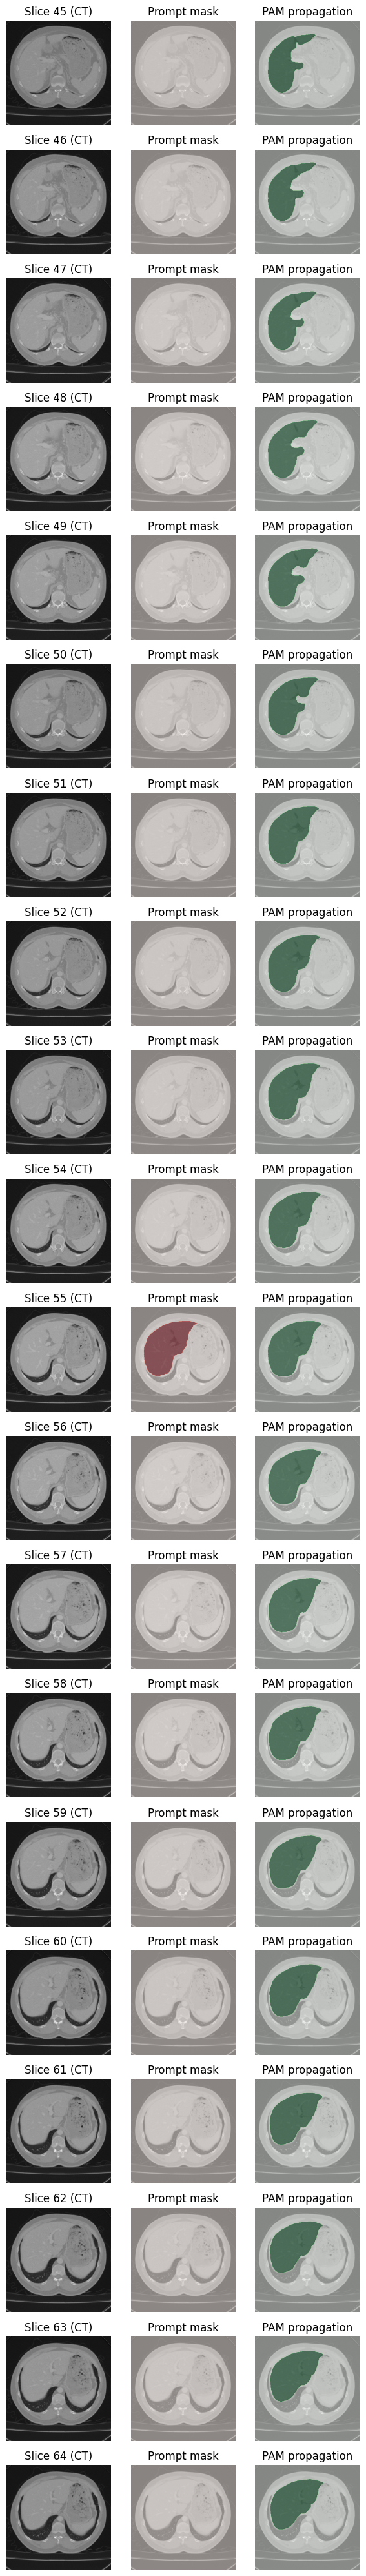

In [8]:
def visualize_slices(z_indices, img_array, prompt_array, pred_array):
    n = len(z_indices)
    fig, axes = plt.subplots(n, 3, figsize=(6, 2 * n))
    if n == 1:
        axes = np.expand_dims(axes, axis=0)
    for row, z in enumerate(z_indices):
        axes[row, 0].imshow(img_array[z], cmap="gray")
        axes[row, 0].set_title(f"Slice {z} (CT)")
        axes[row, 0].axis("off")

        axes[row, 1].imshow(img_array[z], cmap="gray")
        axes[row, 1].imshow(prompt_array[z], alpha=0.5, cmap="Reds")
        axes[row, 1].set_title("Prompt mask")
        axes[row, 1].axis("off")

        axes[row, 2].imshow(img_array[z], cmap="gray")
        axes[row, 2].imshow(pred_array[z], alpha=0.5, cmap="Greens")
        axes[row, 2].set_title("PAM propagation")
        axes[row, 2].axis("off")
    plt.tight_layout()
    plt.show()


prompt_slices = get_prompt_slices(prompt_array)
n_viz_slices = 20
viz_slices = list(range(max(0, int(np.median(prompt_slices)-n_viz_slices//2)), 
                            min(img_array.shape[0]-1, int(np.median(prompt_slices)+n_viz_slices//2))))
visualize_slices(viz_slices, img_array, prompt_array, pred_array)
